# Deep Learning with Weather Data

### In this notebox a temperature forecast is calculated with the help of a fully connected network. The model is based on freely available data from the German Weather Service (DWD) and Open Sense Box data.

In [27]:
from arcgis.gis import GIS
from arcgis import GIS,GeoSeriesAccessor, GeoAccessor
import pandas as pd
import ftplib
import requests
import zipfile
from io import BytesIO
import gzip
import arcpy
from datetime import datetime, timedelta
import arcgis
import arcgis.raster
from arcgis.raster import RasterManager
from arcgis.raster import RasterCatalogItem
# delete irrelevant files
from pathlib import Path
from urllib.parse import urlparse
import re
import os
gis = GIS("home")

#### 1. : Get DWD Data

In [28]:
p = Path("C:/Data/DWD/Berlin_dwd/Temp/")

In [29]:
import requests

url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/P0_Stundenwerte_Beschreibung_Stationen.txt"

#just a random link of a dummy file
r = requests.get(url)
#retrieving data from the URL using get method
with open("C:\Data\DWD\Berlin_dwd\Temp\stations.txt", 'wb') as f:
#giving a name and saving it in any required format
#opening the file in write mode
    f.write(r.content) 
#writes the URL contents from the server

In [30]:
# Get Longitude and Latitude of the station
table_csv_path = r"C:\Data\DWD\dwd.xls" 
stationdf =pd.read_excel(table_csv_path)
stationdf=stationdf.set_index(['Stations_id'])
stationdf

,von_datum,bis_datum,Stationshoehe,geoBreite,geoLaenge,Stationsname,Bundesland
Stations_id,,,,,,,
3,19500401,20110331,202,50.7827,6.0941,Aachen,Nordrhein-Westfalen
44,20070401,20221120,44,52.9336,8.2370,Großenkneten,Niedersachsen
52,19760101,19880101,46,53.6623,10.1990,Ahrensburg-Wulfsdorf,Schleswig-Holstein
71,20091201,20191231,759,48.2156,8.9784,Albstadt-Badkap,Baden-Württemberg
73,20070401,20221120,340,48.6159,13.0506,Aldersbach-Kriestorf,Bayern
...,...,...,...,...,...,...,...
15444,20140901,20221120,593,48.4418,9.9216,Ulm-Mähringen,Baden-Württemberg
15555,20160501,20221120,815,47.8761,10.5849,Kaufbeuren-Oberbeuren,Bayern
15813,20220301,20221120,40,52.5126,7.4131,Lingen-Baccum,Niedersachsen


In [31]:
# Temperature Data

# With stationid load only data of interest
Berlin = ["00303","00400","00403","00420","00427","00433","02856","03376","03987","05825","07389","03015"]


for i in Berlin:
    mytempURL ="https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/air_temperature/recent/stundenwerte_TU_"+i+"_akt.zip"
    #print(mytempURL)
    filename = mytempURL.split('/')[-1]
    req = requests.get(url = mytempURL, stream = False)
    print('Downloading Completed')
    print(req)
        
    # extracting the zip file contents
    zipf= zipfile.ZipFile(BytesIO(req.content))
    zipf.extractall(r'C:\Data\DWD\Berlin_dwd\Temp')
    
# Delete unimportant files    
for file_name in p.glob('*Metadaten*'):
    os.remove(file_name)
    #print('Deleting file:', file_name)

dft_list= []

#Create a dft list
for file_name in p.glob('*produkt_tu*'):
    print(file_name)
    
    dft = pd.read_csv(file_name, sep=";")
    dft=dft.set_index(['STATIONS_ID'])
    dft2022=pd.merge(dft,stationdf,  left_index=True, right_index=True)
    dft2022.index.names = ['Stations_id']
    dft2022.reset_index(inplace = True)
    
    dft_list.append(dft2022)
    
# Create one Dataframe of all elements in df_list
for dft in dft_list:
    dft2022 = dft2022.append([dft])

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_00303.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_00400.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_00403.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_00420.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_00427.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_00433.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_02856.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_03015.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_03376.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_20230119_03987.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_tu_stunde_20210719_2

In [32]:
# precipitation

# With stationid load only data of interest
Berlin = ["00303","00400","00403","00420","00427","00433","02856","03376","03987","05825","07389","03015"]


for i in Berlin:
    mytempURL ="https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/recent/stundenwerte_RR_"+i+"_akt.zip"
    #print(mytempURL)
    filename = mytempURL.split('/')[-1]
    req = requests.get(url = mytempURL, stream = False)
    print('Downloading Completed')
    print(req)
        
    # extracting the zip file contents
    zipf= zipfile.ZipFile(BytesIO(req.content))
    zipf.extractall(r'C:\Data\DWD\Berlin_dwd\Temp')
    
# Delete unimportant files    
for file_name in p.glob('*Metadaten*'):
    os.remove(file_name)
    #print('Deleting file:', file_name)

dfprec_list= []

#Create a dft list
for file_name in p.glob('*produkt_rr*'):
    print(file_name)
    
    dfprec = pd.read_csv(file_name, sep=";")
    dfprec=dfprec.set_index(['STATIONS_ID'])
    dfprec2022=pd.merge(dfprec,stationdf,  left_index=True, right_index=True)
    dfprec2022.index.names = ['Stations_id']
    dfprec2022.reset_index(inplace = True)
    
    dfprec_list.append(dfprec2022)
    
# Create one Dataframe of all elements in df_list
for dfprec in dfprec_list:
    dfprec2022 = dfprec2022.append([dfprec])

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_00303.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_00400.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_00403.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_00420.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_00427.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_00433.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_02856.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_03015.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_03376.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_20230119_03987.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_rr_stunde_20210719_2

In [37]:
# radiation

# With stationid load only data of interest
Berlin = ["00303","00403","00427","00433","03376","03987","05825","07389","03015"]


for i in Berlin:
    mytempURL ="https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/sun/recent/stundenwerte_SD_"+i+"_akt.zip"
    #print(mytempURL)
    filename = mytempURL.split('/')[-1]
    req = requests.get(url = mytempURL, stream = False)
    print('Downloading Completed')
    print(req)
        
    # extracting the zip file contents
    zipf= zipfile.ZipFile(BytesIO(req.content))
    zipf.extractall(r'C:\Data\DWD\Berlin_dwd\Temp')
    
# Delete unimportant files    
for file_name in p.glob('*Metadaten*'):
    os.remove(file_name)
    #print('Deleting file:', file_name)

dfrad_list= []

#Create a dft list
for file_name in p.glob('*produkt_sd*'):
    print(file_name)
    
    dfrad = pd.read_csv(file_name, sep=";")
    dfrad=dfrad.set_index(['STATIONS_ID'])
    dfrad2022=pd.merge(dfrad,stationdf,  left_index=True, right_index=True)
    dfrad2022.index.names = ['Stations_id']
    dfrad2022.reset_index(inplace = True)
    
    dfrad_list.append(dfrad2022)
    
# Create one Dataframe of all elements in df_list
for dfrad in dfrad_list:
    dfrad2022 = dfrad2022.append([dfrad])

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20220622_00303.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20220829_00433.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20230119_00403.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20230119_00427.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20230119_03015.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20230119_03376.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20230119_03987.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20230119_05825.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_sd_stunde_20210719_20230119_07389.txt


In [34]:
# Pressure Data

BerlinPressure = ["00303","00403","00427","00433","03987","03015"]#The other stations have no pressure values

for i in BerlinPressure:
    mypressureURL ="https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_"+i+"_akt.zip"
    print(mypressureURL)
    filename = mypressureURL.split('/')[-1]
    req = requests.get(url = mypressureURL, stream = False)
    print('Downloading Completed')
    print(req)
        
    # extracting the zip file contents
    zipf= zipfile.ZipFile(BytesIO(req.content))
    zipf.extractall(r'C:\Data\DWD\Berlin_dwd\Temp')
    
for file_name in p.glob('*Metadaten*'):
    os.remove(file_name)
    #print('Deleting file:', file_name)  
    

dfp_list= []

for file_name in p.glob('*produkt_p0*'):
    print(file_name)
    
    dfp = pd.read_csv(file_name, sep=";")
    dfp=dfp.set_index(['STATIONS_ID'])
    dfp2022=pd.merge(dfp,stationdf,  left_index=True, right_index=True)
    dfp2022.index.names = ['Stations_id']
    dfp2022.reset_index(inplace = True)
    
    dfp_list.append(dfp2022)
    
# Create one Dataframe of all elements in df_list
for dfp in dfp_list:
    dfp2022 = dfp2022.append([dfp])

https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_00303_akt.zip
<Response [200]>
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_00403_akt.zip
<Response [200]>
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_00427_akt.zip
<Response [200]>
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_00433_akt.zip
<Response [200]>
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_03987_akt.zip
<Response [200]>
https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/pressure/recent/stundenwerte_P0_03015_akt.zip
<Response [200]>
C:\Data\DWD\Berlin_dwd\Temp\produkt_p0_stunde_20210719_20230119_00303.txt
C:\Data\DWD\Berlin_dwd\Temp\produkt_p0_stund

In [39]:
# Merge temperature df and pressure df

df2022 = pd.concat([dfp2022,dft2022,dfprec2022, dfrad2022])
df2022

,Stations_id,MESS_DATUM,QN_8,P,P0,eor,von_datum,bis_datum,Stationshoehe,geoBreite,...,Stationsname,Bundesland,QN_9,TT_TU,RF_TU,R1,RS_IND,WRTR,QN_7,SD_SO
0,3987,2021071900,3.0,1018.4,1006.7,eor,18930101,20221120,82,52.3812,...,Potsdam,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3987,2021071901,3.0,1018.6,1006.8,eor,18930101,20221120,82,52.3812,...,Potsdam,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3987,2021071902,3.0,1018.9,1007.1,eor,18930101,20221120,82,52.3812,...,Potsdam,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3987,2021071903,3.0,1019.4,1007.5,eor,18930101,20221120,82,52.3812,...,Potsdam,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3987,2021071904,3.0,1019.8,1007.9,eor,18930101,20221120,82,52.3812,...,Potsdam,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10172,7389,2023011919,NaN,NaN,NaN,eor,20061201,20221120,83,52.7461,...,Heckelberg,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
10173,7389,2023011920,NaN,NaN,NaN,eor,20061201,20221120,83,52.7461,...,Heckelberg,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
10174,7389,2023011921,NaN,NaN,NaN,eor,20061201,20221120,83,52.7461,...,Heckelberg,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0
10175,7389,2023011922,NaN,NaN,NaN,eor,20061201,20221120,83,52.7461,...,Heckelberg,Brandenburg,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0


In [40]:
#Check colnames of interest

for col in df2022.columns:
    print(col)

Stations_id
MESS_DATUM
QN_8
   P
  P0
eor
von_datum
bis_datum
Stationshoehe
geoBreite
geoLaenge
Stationsname
Bundesland
QN_9
TT_TU
RF_TU
  R1
RS_IND
WRTR
QN_7
SD_SO


In [10]:
# Meaning:
    #TT_TU Lufttemperatur in 2m Höhe
    #RF_TU relative Feuchte
    #P Luftdruck auf Meereshöhe NN hPA
    #P0 Luftdruck auf Stationshöhe

# Rename df2022 to get asimilar df as the one of the sense box data

df2022=df2022.rename(columns={'Stations_id':'ID','MESS_DATUM':'date','geoBreite':'Latitude','geoLaenge':'Longitude','Messdatum':'date','TT_TU':'Temperatur','RF_TU':'relLuftfeuchte', '   P':'Luftdruck'})
df2022 = df2022.drop(['QN_8','  P0','eor','von_datum','bis_datum','Stationshoehe','Stationsname','Bundesland','QN_9'], axis=1)
df2022

,ID,date,Luftdruck,Latitude,Longitude,Temperatur,relLuftfeuchte
0,3987,2021071800,1019.4,52.3812,13.0622,18.2,81.0
1,3987,2021071800,1019.4,52.3812,13.0622,18.2,81.0
2,3987,2021071801,1019.6,52.3812,13.0622,17.1,87.0
3,3987,2021071801,1019.6,52.3812,13.0622,17.1,87.0
4,3987,2021071802,1019.5,52.3812,13.0622,16.6,86.0
...,...,...,...,...,...,...,...
92393,3015,2023011819,1000.1,52.2085,14.1180,0.2,97.0
92394,3015,2023011820,1001.0,52.2085,14.1180,0.2,97.0
92395,3015,2023011821,1001.5,52.2085,14.1180,-0.5,96.0
92396,3015,2023011822,1002.1,52.2085,14.1180,-0.3,97.0


### Get Opensensemap Data

In [15]:
# Registration in GIS
agol = GIS("home")

In [16]:
# URL of the API in JSON-format
base_url = 'https://api.opensensemap.org/boxes?&full=true'

In [17]:
# Query the timestamp from 15 minutes ago
timestamp = datetime.utcnow() - timedelta(minutes=15)


In [18]:
# Abfrage the sensebox data that are max 15 minutes old
url = base_url +'&date='+str(timestamp.isoformat("T") + "Z") +'&bbox='+str(11.839449) +','+str(51.866560)+','+str(15.182040) +','+str(53.006758)

In [19]:
%%time
# Transfer the JSON queried in the API into a dataframe
try:
    df = pd.read_json(url,encoding='utf-8')
except:
    raise SystemExit('ERROR: Fehlerhafte Abfrage der OpenSense API!')

Wall time: 10.4 s


In [20]:
if df.shape[0] > 0:
    print('Die Abfrage der OpenSense API war erfolgreich.')
else:
    raise SystemExit('ERROR: Fehlerhafte Abfrage der OpenSense API!')

Die Abfrage der OpenSense API war erfolgreich.


In [21]:
# create a list of all keywords of a phenomenon used in the data

# Access to the "sensors" column and into the respective phenomenon
phenomenom_array = []
for index, row in df.iterrows():
    for i in row['sensors']:
# Try to add each "title" of the phenomena to the list
        try:
            phenomenom_array.append(i['title'])
        except KeyError:
            continue
phenomenom_list = list(set(phenomenom_array))

In [22]:
# Create different phaenomena lists from the phaenomen_list (of all existing phaenomena).
luftfeuchte = [s for s in phenomenom_list if "Luftfeuchte" in s] + [s for s in phenomenom_list if "Humidity" in s] + [s for s in phenomenom_list if "Luftfeuchtigkeit" in s]
temperatur = [s for s in phenomenom_list if "Temperatur" in s] + [s for s in phenomenom_list if "Temperature" in s] + [s for s in phenomenom_list if "Lufttemperatur" in s]
luftdruck = [s for s in phenomenom_list if "Luftdruck" in s] + [s for s in phenomenom_list if "Pressure" in s]
beleuchtungsstaerke = [s for s in phenomenom_list if "Beleuchtungsstärke" in s] + [s for s in phenomenom_list if "Helligkeit" in s] + [s for s in phenomenom_list if "light intesity" in s]
uv_intesitaet = [s for s in phenomenom_list if "UV Intensitaet" in s] + [s for s in phenomenom_list if "UV" in s] + [s for s in phenomenom_list if "UV intensity" in s]
pm10 = [s for s in phenomenom_list if "pm10" in s] + [s for s in phenomenom_list if "PM10" in s]
pm25 = [s for s in phenomenom_list if "pm2.5" in s] + [s for s in phenomenom_list if "PM25" in s] + [s for s in phenomenom_list if "PM2.5" in s]

In [23]:
# Restructuring of the pandas dataframes, so that each phenomenon and its value is in its own column
data = []
for index, row in df.iterrows():
# access and save the different columns in their own variables to add them to the dataframe later on
    #timestamp = df.loc[index,'currentLocation']['timestamp']
    # query Longitude 
    lon = df.loc[index,'currentLocation']['coordinates'][0]
    # query Latitude
    lat = df.loc[index,'currentLocation']['coordinates'][1]
    id_ = df.loc[index,'_id']
    name_ = df.loc[index,'name']
    grouptag_ = str(df.loc[index,'grouptag'])
    exposure_ = df.loc[index,'exposure']
    model_ = df.loc[index,'model']
    description_ = str(df.loc[index,'description'])
    weblink_ = str(df.loc[index,'weblink'])
    image_ = str(df.loc[index,'image'])
    
#     for element in df.loc[index,'sensors']:
#         if element['lastMeasurement']:
#             lastMeasurementAt_ = element['lastMeasurement']['createdAt']
#             break
#         else: 
#             lastMeasurementAt_ = None

    for a in range(len(df.loc[index, 'sensors'])):
        try:
            lastMeasurementAt_ = df.loc[index, 'sensors'][a]['lastMeasurement']['createdAt']
            if lastMeasurementAt_ != None:
                break
            else:
                lastMeasurementAt_ == None
        except:
            lastMeasurementAt_ == None
            
#     try:
#         # Zeit der letzten Messung des ersten verfeugbaren Sensors abfragen, falls dieser vorhanden ist.
#         lastMeasurementAt_ = df.loc[index,'sensors'][0]['lastMeasurement']['createdAt']
#         #lastMeasurementAt_ = df.loc[index,'lastMeasurementAt']
#             # Column 'LastMeasurementAt' ist nicht bei jedem Sensor vorhanden, daher nehmen wir 
#             # df.loc[index,'sensors'][0]['lastMeasurement']['createdAt'], da dieser Wert für jeden Sensor verfügbar ist
#     except:
#         lastMeasurementAt_ = None
    
    # Query the values of the Phaenoma
    sensor_data={}
    for i in row['sensors']:
        try:
            # access to every single value of the sensor data, filling the empty sensor_data dictionary
            sensor_data[i['title']]=round(float(i['lastMeasurement']['value']),2)
        except Exception as E:
            continue
    # the previously empty data dictionary is filled with the corresponding values:
    # at the phenomena values: it is searched for the keywords of the above created temperature, humidity, etc lists
    try:
        data.append(
            {
            'ID': id_[:49],
            'Name': name_[:249],
            'Longitude': lon,
            'Latitude':  lat,
            'Grouptag': grouptag_[:249],
            'Exposure': exposure_[:249],
            'LetzteMessung':lastMeasurementAt_,
            'Temperatur': next((sensor_data.get(key) for key in temperatur if key in sensor_data), None),
            'relLuftfeuchte' : next((sensor_data.get(key) for key in luftfeuchte if key in sensor_data), None),
            'Luftdruck': next((sensor_data.get(key) for key in luftdruck if key in sensor_data), None),
            'Beleuchtungsstärke': next((sensor_data.get(key) for key in beleuchtungsstaerke if key in sensor_data), None),
            'UVIntensität': next((sensor_data.get(key) for key in uv_intesitaet if key in sensor_data), None),
            'PM10': next((sensor_data.get(key) for key in pm10 if key in sensor_data), None),
            'PM25': next((sensor_data.get(key) for key in pm25 if key in sensor_data), None),
            'Model': model_[:249],
            'Description': description_[:249],
            'Weblink': weblink_[:249],
            'Image': image_[:249],
            }
        )
    except KeyError:
        continue

# Creating the pandas dataframe from the sensor dictionary
df_out=pd.DataFrame(data)
# # Convert "LetzteMessung" column to datetime format
df_out['LetzteMessung'] = df_out['LetzteMessung'].astype('datetime64[ns]')
#delete incorrectly queried old data
up_date_15minutes = datetime.utcnow() - timedelta(minutes=15)
df_out = df_out[~(df_out['LetzteMessung'] < up_date_15minutes)]

In [24]:
from datetime import datetime
#df_out=df_out.drop(["Name", "Description","Weblink", "Image"], axis=1)
#df_out['LetzteMessung']=pd.to_datetime(df_out['LetzteMessung'])
#df_out['LetzteMessung'] = pd.to_datetime(df_out['LetzteMessung'],format='%d%m%Y%hh')
d=df_out['LetzteMessung'].astype(str)
df_out['date'] = d.str[:4]+d.str[5:7]+d.str[8:10]+d.str[11:13]
df_out = df_out.drop(['Name','Grouptag','Exposure','LetzteMessung','Beleuchtungsstärke','Model','Description','Weblink','Image'], axis=1)
df_out

,ID,Longitude,Latitude,Temperatur,relLuftfeuchte,Luftdruck,UVIntensität,PM10,PM25,date
0,582473be40198a001010e1a3,13.302834,52.457219,0.89,99.99,1009.34,56.25,3.50,2.20,2023012008
1,5889cb92ff876d00101be9dd,13.380978,52.465227,3.29,87.88,1009.74,5.63,NaN,NaN,2023012008
2,58fb1549635722001156933b,13.164529,52.188587,-129.25,99.90,65468.00,NaN,16.27,13.40,2023012008
3,592ca4b851d3460011ea2635,13.392964,52.510969,20.90,68.90,NaN,NaN,55.40,23.40,2023012008
6,595178fb94f0520011e083ec,13.541057,52.419490,2.00,1.00,NaN,NaN,34.58,19.00,2023012008
...,...,...,...,...,...,...,...,...,...,...
146,62f3be8ea6e889001bf6b775,13.121691,52.509501,4.79,62.93,101.29,NaN,35.21,27.43,2023012008
150,637e57b6950503001b3712a2,13.564355,52.516286,-0.14,99.92,100851.97,NaN,43.53,23.85,2023012008
155,6394ff47a7390d001b86d457,13.392956,52.511162,13.20,39.60,NaN,NaN,3.10,2.80,2023012008
157,6398c664a7390d001b5e0742,13.381320,52.458560,0.53,91.77,NaN,16.88,13.90,3.60,2023012008


In [25]:
# Merge DWD df and sensebox df
df=pd.concat([df2022,df_out])
df

,ID,date,Luftdruck,Latitude,Longitude,Temperatur,relLuftfeuchte,UVIntensität,PM10,PM25
0,3987,2021071800,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN
1,3987,2021071800,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN
2,3987,2021071801,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN
3,3987,2021071801,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN
4,3987,2021071802,1019.50,52.381200,13.062200,16.60,86.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
146,62f3be8ea6e889001bf6b775,2023012008,101.29,52.509501,13.121691,4.79,62.93,NaN,35.21,27.43
150,637e57b6950503001b3712a2,2023012008,100851.97,52.516286,13.564355,-0.14,99.92,NaN,43.53,23.85
155,6394ff47a7390d001b86d457,2023012008,NaN,52.511162,13.392956,13.20,39.60,NaN,3.10,2.80
157,6398c664a7390d001b5e0742,2023012008,NaN,52.458560,13.381320,0.53,91.77,16.88,13.90,3.60


In [26]:
# Convert Datetime
d=df['date'].astype(str)
df['date'] = d.str[:4] + "-" + d.str[4:6]+ "-" + d.str[6:8]
df

,ID,date,Luftdruck,Latitude,Longitude,Temperatur,relLuftfeuchte,UVIntensität,PM10,PM25
0,3987,2021-07-18,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN
1,3987,2021-07-18,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN
2,3987,2021-07-18,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN
3,3987,2021-07-18,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN
4,3987,2021-07-18,1019.50,52.381200,13.062200,16.60,86.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
146,62f3be8ea6e889001bf6b775,2023-01-20,101.29,52.509501,13.121691,4.79,62.93,NaN,35.21,27.43
150,637e57b6950503001b3712a2,2023-01-20,100851.97,52.516286,13.564355,-0.14,99.92,NaN,43.53,23.85
155,6394ff47a7390d001b86d457,2023-01-20,NaN,52.511162,13.392956,13.20,39.60,NaN,3.10,2.80
157,6398c664a7390d001b5e0742,2023-01-20,NaN,52.458560,13.381320,0.53,91.77,16.88,13.90,3.60


In [27]:
df_new = df
df_new['date'] = pd.to_datetime(df_new['date'])
df_new

,ID,date,Luftdruck,Latitude,Longitude,Temperatur,relLuftfeuchte,UVIntensität,PM10,PM25
0,3987,2021-07-18,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN
1,3987,2021-07-18,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN
2,3987,2021-07-18,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN
3,3987,2021-07-18,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN
4,3987,2021-07-18,1019.50,52.381200,13.062200,16.60,86.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
146,62f3be8ea6e889001bf6b775,2023-01-20,101.29,52.509501,13.121691,4.79,62.93,NaN,35.21,27.43
150,637e57b6950503001b3712a2,2023-01-20,100851.97,52.516286,13.564355,-0.14,99.92,NaN,43.53,23.85
155,6394ff47a7390d001b86d457,2023-01-20,NaN,52.511162,13.392956,13.20,39.60,NaN,3.10,2.80
157,6398c664a7390d001b5e0742,2023-01-20,NaN,52.458560,13.381320,0.53,91.77,16.88,13.90,3.60


In [ ]:
df_new.to_csv('C:/Data/DWD/Berlin_dwd/Temp/inputdata.csv', index = True)

In [51]:
# Create Spatial Dataframe for Trainingt to use raster data

sdf=pd.DataFrame.spatial.from_xy(df_new,"Longitude","Latitude",sr=3857)
sdf

,ID,date,Luftdruck,Latitude,Longitude,Temperatur,relLuftfeuchte,UVIntensität,PM10,PM25,SHAPE
0,3987,2021-07-18,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.0..."
1,3987,2021-07-18,1019.40,52.381200,13.062200,18.20,81.00,NaN,NaN,NaN,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.0..."
2,3987,2021-07-18,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.0..."
3,3987,2021-07-18,1019.60,52.381200,13.062200,17.10,87.00,NaN,NaN,NaN,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.0..."
4,3987,2021-07-18,1019.50,52.381200,13.062200,16.60,86.00,NaN,NaN,NaN,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.0..."
...,...,...,...,...,...,...,...,...,...,...,...
146,62f3be8ea6e889001bf6b775,2023-01-20,101.29,52.509501,13.121691,4.79,62.93,NaN,35.21,27.43,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.1..."
150,637e57b6950503001b3712a2,2023-01-20,100851.97,52.516286,13.564355,-0.14,99.92,NaN,43.53,23.85,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.5..."
155,6394ff47a7390d001b86d457,2023-01-20,NaN,52.511162,13.392956,13.20,39.60,NaN,3.10,2.80,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.3..."
157,6398c664a7390d001b5e0742,2023-01-20,NaN,52.458560,13.381320,0.53,91.77,16.88,13.90,3.60,"{""spatialReference"": {""wkid"": 3857}, ""x"": 13.3..."


In [62]:
# Here a list is created naming all fields containing the predictors from the input feature layer
X = ['Temperatur','relLuftfeuchte','UVIntensität','PM10','PM25']

In [63]:
# importing the libraries from arcgis.learn for data preprocessing
from arcgis.learn import prepare_tabulardata
from arcgis.raster import Raster

In [54]:
# Load Landcover Data from Image Server
lc=Raster(path="https://ic.imagery1.arcgis.com/arcgis/rest/services/Sentinel2_10m_LandCover/ImageServer",
                     is_multidimensional=False,
                     extent={"xmin" : 11.839449,"ymin" : 51.866560,"xmax" : 15.182040,"ymax" : 53.006758,"spatialReference" :{ "wkid" : 4326 }})
explanatory_rasters = [(lc,True)]

In [55]:
# With raster data
# precrocessing data using prepare data method - it handles imputing missing values, normalization and train-test split
data = prepare_tabulardata(sdf,
                           'Temperatur',
                           explanatory_variables=X,
                           explanatory_rasters=explanatory_rasters)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1364: UserWarning: Dataframe is not spatial, Rasters and distance layers will not work
  warnings.warn(


In [64]:
# Without raster data
# precrocessing data using prepare data method - it handles imputing missing values, normalization and train-test split
data = prepare_tabulardata(df_new,
                           'Luftdruck',
                           explanatory_variables=X)

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1364: UserWarning: Dataframe is not spatial, Rasters and distance layers will not work
  warnings.warn(


In [65]:
# visualizing the prepared data 
data.show_batch()

,Luftdruck,PM10,PM25,Temperatur,UVIntensität,relLuftfeuchte
4592,999.6,NaN,NaN,12.0,NaN,64.0
9195,1031.3,NaN,NaN,4.2,NaN,93.0
49055,1006.3,NaN,NaN,19.0,NaN,98.0
62599,1022.7,NaN,NaN,18.8,NaN,74.0
73196,1018.5,NaN,NaN,13.3,NaN,66.0


In [66]:
# importing the model from arcgis.learn
from arcgis.learn import FullyConnectedNetwork
from arcgis.learn import MLModel

In [67]:
# defining the unsupervised mlmodel with a Gaussian mixture model along with the parameters  
#model = MLModel(data, 'sklearn.ensemble.GradientBoostingRegressor', n_estimators=100, random_state=43)

In [68]:
# Initialize the model with the data where the weights are randomly allocated
fcn = FullyConnectedNetwork(data, layers=[200, 300])

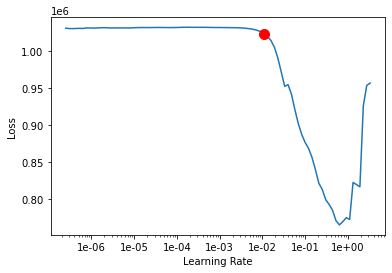

0.01096478196143185

In [69]:
# searching for an optimal learning rate using the lr_find for passing it to the final model fitting 
l_rate = fcn.lr_find()
l_rate

In [70]:
# the model is trained for 100 epochs 
fcn.fit(20,lr=l_rate)

epoch,train_loss,valid_loss,time
0,1649365760.000000,42133164032.000000,00:06
1,63782428.000000,6552673792.000000,00:08
2,402520.156250,113206566912.000000,00:08
3,1009292.062500,1535976832.000000,00:07
4,176201.781250,14790554550272.000000,00:08
5,48097552.000000,180841463808.000000,00:08
6,1311274112.000000,575086400.000000,00:09
7,45928980480.000000,2915413248.000000,00:09
8,859025.000000,5005652480.000000,00:08
9,2081752.125000,919588241408.000000,00:09


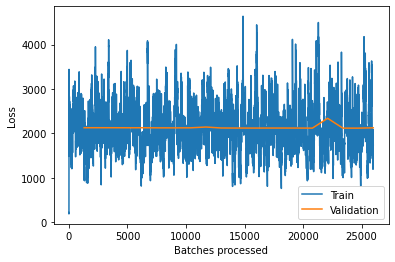

In [61]:
# the train vs valid losses is plotted to check quality of the trained model
fcn.plot_losses()

In [50]:
# the predicted values by the trained model is printed for the test set
fcn.show_results()

,Luftdruck,PM10,PM25,Temperatur,UVIntensität,relLuftfeuchte,prediction_results
64106,1014.8,31.1,17.9,10.5,16.88,99.0,0.122054
21206,1015.9,31.1,17.9,10.6,16.88,-999.0,0.418219
1276,1018.9,31.1,17.9,28.9,16.88,43.0,0.135208
77607,1026.3,31.1,17.9,8.0,16.88,87.0,0.116704
25008,1012.5,31.1,17.9,4.8,16.88,94.0,0.119133
